### Auditory Oddball ERP analysis: data visualisation
An example of visualising auditory oddball data within multiple timepoints (or groups) at one channel.

In [21]:
# Import packages
import mne, os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns

# Set the default directory
os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')

# Ignore warnings from plotting and display only errors for MNE
mne.set_log_level('error')

# Import functions
import basic.arrange_data as arrange
import signal_processing.erp_analysis as erpan

## Pre-processing

## ERP detection

In [ ]:
# Folder where to get the clean epochs files
clean_folder = 'Data/Clean/'

# Folder where to save the results and plots
results_folder = 'Results/'

# Sub-folder for the experiment (i.e. timepoint or group) and its acronym
exp_folder = 'OKTOS'
exp_condition = '/Auditory Oddball/Baseline'
exp_condition_code = 'AO_00'

# Time windows for different ERP components
# {'ERP_name' : [t1, t2, pos/neg]}
erp_wins = {'P3' : [270, 500, 1]}

# Channel of interest
channel_pick = 'Cz'

# Event names (i.e. different stimuli) within the epochs
event_list = ['target after 1 standard', 'target after 3 standards', 'target after 5 standards',
              'target after 7 standards', 'target after 9 standards', 'target after 11 standards']

# Get directories of clean EEG files and set export directory
dir_inprogress = os.path.join(clean_folder, exp_folder+exp_condition)
file_dirs, subject_names = arrange.read_files(dir_inprogress, '_clean-epo.fif')

In [ ]:
# Loop through all the subjects' directories (EEG files directories)
df_erps = pd.DataFrame()
evoked_signal = [None]*len(file_dirs)

arrange.create_results_folders(exp_folder=exp_folder+exp_condition,results_folder=results_folder, erps=True)

for i in range(len(file_dirs)):
    erp_wins_temp = erp_wins
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress, subject_names[i]), verbose=False)
    
    # Create an averaged evoked object from epochs
    evoked_signal[i] = epochs[event_list].average(picks=channel_pick)

    # Find all the peaks in the evoked signal
    minpeak_times, minpeak_mags, maxpeak_times, maxpeak_mags = erpan.find_all_peaks(evoked_signal[i],
                                                                                    epochs, thresh=None,
                                                                                    subject_name=subject_names[i],
                                                                                    verbose=False, plot=False)
    
    # Identify which peaks are which ERPs based on the pre-defined ERP time windows
    erp_peaks, not_erp_peaks = erpan.identify_erps(evoked_signal[i], erp_wins_temp, minpeak_times, minpeak_mags,
                                                   maxpeak_times, maxpeak_mags, subject_name=subject_names[i],
                                                   verbose=False, plot=True, savefig=True,
                                                   results_foldername=results_folder, exp_folder=exp_folder+exp_condition)

    # After visual inspection, it's possible to re-define the time windows to look for the peak
    while input('Do you need to do any manual time window changes? (leave empty if "no")') != '':
        print('Changing time window parameters for {}'.format(subject_names[i]))
        new_time_win = [None, None, None]

        # Ask user for which ERP they want to change or add
        erp_tochange = input('What ERP time window you want to change (e.g., N1)?')

        # Ask user what should be the minimum timepoint of the time window for that ERP
        new_time_win[0] = int(input('Enter MIN time of the window in interest for {} (e.g., 50)'.format(erp_tochange)))

        # Ask user what should be the maximum timepoint of the time window for that ERP
        new_time_win[1] = int(input('Enter MAX time of the window in interest for {} (e.g., 100)'.format(erp_tochange)))

        # Ask user whether this ERP should be a postitive (1) or negative (-1) peak
        new_time_win[2] = int(input('Enter whether to look for MIN (-1) or MAX (1) voltage for {}'.format(erp_tochange)))

        # Change the temporary ERP time window parameters to the user inputted parameters
        erp_wins_temp[erp_tochange] = new_time_win
        print('Changing', erp_tochange, 'with new time window:', str(new_time_win))

        # Use these new parameters to find either minimum or maximum value in that range
        try:
            erp_peaks = erpan.find_minmax_erp(evoked_signal[i], erp_peaks, erp_tochange, new_time_win,
                                              subject_name=subject_names[i], verbose=False, plot=True,
                                              savefig=True, results_foldername=results_folder, exp_folder=exp_folder+exp_condition)
        except:
            print('Something went wrong with manual ERP detection, try again.')

    # Add this/these new temporary ERP to the main dataframe
    df_erps_temp = erpan.erp_dict_to_df(erp_peaks, erp_wins_temp, subject_names[i])
    df_erps = pd.concat([df_erps, df_erps_temp])
    print('ERPs have been found and added to the dataframe for {}'.format(subject_names[i]))
    display(df_erps)

# Export all the detected ERPs to an Excel spreadsheet
display(df_erps)
df_erps.to_excel('{}/{}/Auditory Oddball/{}/{}_{}_grandaverage_erps.xlsx'.format(results_folder, exp_folder,
                                                                channel_pick, exp_condition_code,
                                                                channel_pick))

## Analysis
Artefactual removes: 'OKTOS_0019', 'OKTOS_0024', 'OKTOS_0033'

In [4]:
# Folder where to get the clean epochs files
clean_folder = 'Data/Clean/'

# Folder where to save the plots
results_folder = 'Results/'

# Sub-folders for experiments (i.e. timepoints or groups) and their acronyms
exp_folder = 'OKTOS'
exp_condition = 'Auditory Oddball'
dict_timepoint = {'00A' : 'PRE', '06D' : 'POST', '07A' : 'FUP'}

# Channels and ERPs of interest
channels = ['Cz', 'Pz']
erp_measures = ['P3_latency', 'P3_amplitude']

# Export the master dataframe used for analysis or not
export_df = True

### PLOTTING ONLY

# Timepoint folders for EEG files (.fif)
timepoint_folders = ['Auditory Oddball/Baseline',
                     'Auditory Oddball/6 weeks',
                     'Auditory Oddball/10 weeks']

# Subjects which to not plot (which have been removed from analysis)
bad_subjects = ['OKTOS_0019', 'OKTOS_0024', 'OKTOS_0033']

# Event names (i.e. different stimuli) within the epochs, which to average
event_list = ['target after 1 standard', 'target after 3 standards', 'target after 5 standards',
              'target after 7 standards', 'target after 9 standards', 'target after 11 standards']

# Export the figure to results folder or not
savefig = True

In [5]:
# Read in the clinical data
dir_inprogress = os.path.join(clean_folder, exp_folder, exp_condition)
file_dirs, file_names = arrange.read_files(dir_inprogress, '.xlsx')
df_clinical = pd.read_excel(file_dirs[0])

# For each channel, merge the ERP dataframe with the clinical dataframe
df = pd.DataFrame()
for ch in channels:
    # Read in the ERP data for all timepoints
    dir_inprogress = os.path.join(results_folder, exp_folder, exp_condition, ch)
    file_dirs, file_names = arrange.read_files(dir_inprogress, '.xlsx')

    # Merge all timepoints' dataframes together for the current channel
    df_erps = pd.DataFrame()
    for file in file_dirs:
        df_erps_temp = pd.read_excel(file).rename(columns={'Unnamed: 0' : 'Subject'})\
                                        .sort_values(by=['Subject'])\
                                        .reset_index(drop=True)

        # Modify column names and remove suffix from the subject names
        df_erps_temp.columns = [c.replace(' ', '_') for c in df_erps_temp.columns]
        df_erps_temp.columns = [c.replace('-', '_') for c in df_erps_temp.columns]
        df_erps_temp['Subject'] = df_erps_temp['Subject'].str.removesuffix('_AO')
        
        # Merge to the all channels dataframe
        df_erps = pd.concat([df_erps, df_erps_temp])

    # Merge the clinical data to ERP data
    df_ch = df_erps.merge(df_clinical)

    # Extract timepoint from subject name code
    for i in range(len(df_ch)):
        full_subjectname = df_ch.loc[i, 'Subject']
        df_ch.loc[i, 'Subject'] = full_subjectname.rsplit('_', 1)[0]
        df_ch.loc[i, 'Timepoint'] = full_subjectname.rsplit('_', 1)[1]

    # Add channel name column
    df_ch['Channel'] = ch #################
    df_ch.insert(1, 'Channel', df_ch.pop('Channel'))

    # Change timepoint values from dictionary
    df_ch.insert(1, 'Timepoint', df_ch.pop('Timepoint'))
    df_ch['Timepoint'] = df_ch['Timepoint'].replace(dict_timepoint)

    # Merge channel dataframe to master dataframe
    df = pd.concat([df, df_ch])

# Modify column names 
df.columns = [c.replace(' ', '_') for c in df.columns]

# Display the master dataframe and export
display(df)
if export_df==True:
    df.to_excel('{}/{}/OKTOS_AO_df.xlsx'.format(results_folder, exp_folder))


Files in Data/Clean/OKTOS/Auditory Oddball read in: 1
Files in Results/OKTOS/Auditory Oddball/Cz read in: 3
Files in Results/OKTOS/Auditory Oddball/Pz read in: 3


,Subject,Timepoint,Channel,P3_latency,P3_amplitude,BSS,DASS21_(Depression),DASS21_(Anxiety),DASS21_(Stress),Gender_(F),Age,Responder
0,OKTOS_0001,PRE,Cz,357.421875,2.063690,20,38,16,26,0,63.15934,1
1,OKTOS_0002,PRE,Cz,329.101562,5.679291,12,26,18,28,0,32.34615,1
2,OKTOS_0003,PRE,Cz,321.289062,0.923549,24,42,6,30,1,45.62088,0
3,OKTOS_0006,PRE,Cz,291.015625,2.349170,14,28,14,12,1,58.63187,1
4,OKTOS_0007,PRE,Cz,356.445312,2.555908,17,38,30,26,0,42.33516,1
...,...,...,...,...,...,...,...,...,...,...,...,...
67,OKTOS_0029,FUP,Pz,399.414062,0.220527,0,8,0,0,0,71.80495,1
68,OKTOS_0031,FUP,Pz,389.648438,5.566867,14,24,14,30,1,38.70879,0
69,OKTOS_0035,FUP,Pz,355.468750,3.206366,0,4,12,12,1,55.85714,1
70,OKTOS_0038,FUP,Pz,299.804688,2.465057,21,36,20,26,1,24.11264,0


In [6]:
# Go through all channels of interest
for ch in channels:
    print('\nChannel: {}'.format(ch))
    df_ch = df[df['Channel']==ch]

    # Make the Timepoint a categorical column
    df_ch_cat = df_ch.copy()
    df_ch_cat['Timepoint'] = pd.Categorical(df_ch_cat['Timepoint'], categories=['PRE', 'POST', 'FUP'], ordered=True)

    # Run Mixed Linear Model for all ERP measures of interest as dependent variable
    for erp in erp_measures:
        # Define the model as fixed effects being Timepoint and Responder and random effect being group (i.e., Subject)
        model = smf.mixedlm('{} ~ Timepoint * Responder'.format(erp), df_ch_cat, groups=df_ch_cat['Subject'], re_formula='Timepoint:Responder')
        result = model.fit(method='lbfgs', maxiter=2000)
        print(result.summary())


Channel: Cz
                                 Mixed Linear Model Regression Results
Model:                             MixedLM                Dependent Variable:                P3_latency
No. Observations:                  72                     Method:                            REML      
No. Groups:                        24                     Scale:                             410.1699  
Min. group size:                   3                      Log-Likelihood:                    -335.1017 
Max. group size:                   3                      Converged:                         Yes       
Mean group size:                   3.0                                                                 
-------------------------------------------------------------------------------------------------------
                                                          Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------------

/Users/tanijarv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                                 Mixed Linear Model Regression Results
Model:                             MixedLM                Dependent Variable:                P3_latency
No. Observations:                  72                     Method:                            REML      
No. Groups:                        24                     Scale:                             240.7947  
Min. group size:                   3                      Log-Likelihood:                    -322.5469 
Max. group size:                   3                      Converged:                         Yes       
Mean group size:                   3.0                                                                 
-------------------------------------------------------------------------------------------------------
                                                          Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------------------------

/Users/tanijarv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


The correct way to calculate the mean amplitude for Responders at POST and FUP is to combine the coefficients of the corresponding terms in the model. Here's the correct way to calculate the mean amplitude for each combination of Timepoint and Responder:

- Non-responder at PRE (baseline): `Intercept`
- Non-responder at POST: `Intercept + Timepoint[T.POST]`
- Non-responder at FUP: `Intercept + Timepoint[T.FUP]`
- Responder at PRE: `Intercept + Responder`
- Responder at POST: `Intercept + Responder + Timepoint[T.POST] + Timepoint[T.POST]:Responder`
- Responder at FUP: `Intercept + Responder + Timepoint[T.FUP] + Timepoint[T.FUP]:Responder`

- `result.params`: Model coefficients.
- `result.bse`: Standard errors of the coefficients.
- `result.conf_int()`: Confidence intervals for the coefficients.
- `result.fe_params`: Fixed effects parameters.
- `result.random_effects`: Random effects estimates for each group.
- `result.cov_re`: Covariance matrix of the random effects.

In [6]:
print(result.conf_int())

                                    0         1
Intercept                    0.802522  3.477604
Timepoint[T.POST]           -0.453815  1.645406
Timepoint[T.FUP]            -0.583425  1.515796
Responder                   -0.287708  2.988585
Timepoint[T.POST]:Responder -2.698193 -0.127183
Timepoint[T.FUP]:Responder  -2.466556  0.104454
Group Var                    0.379665  4.115914


## Visualisation (WIP)

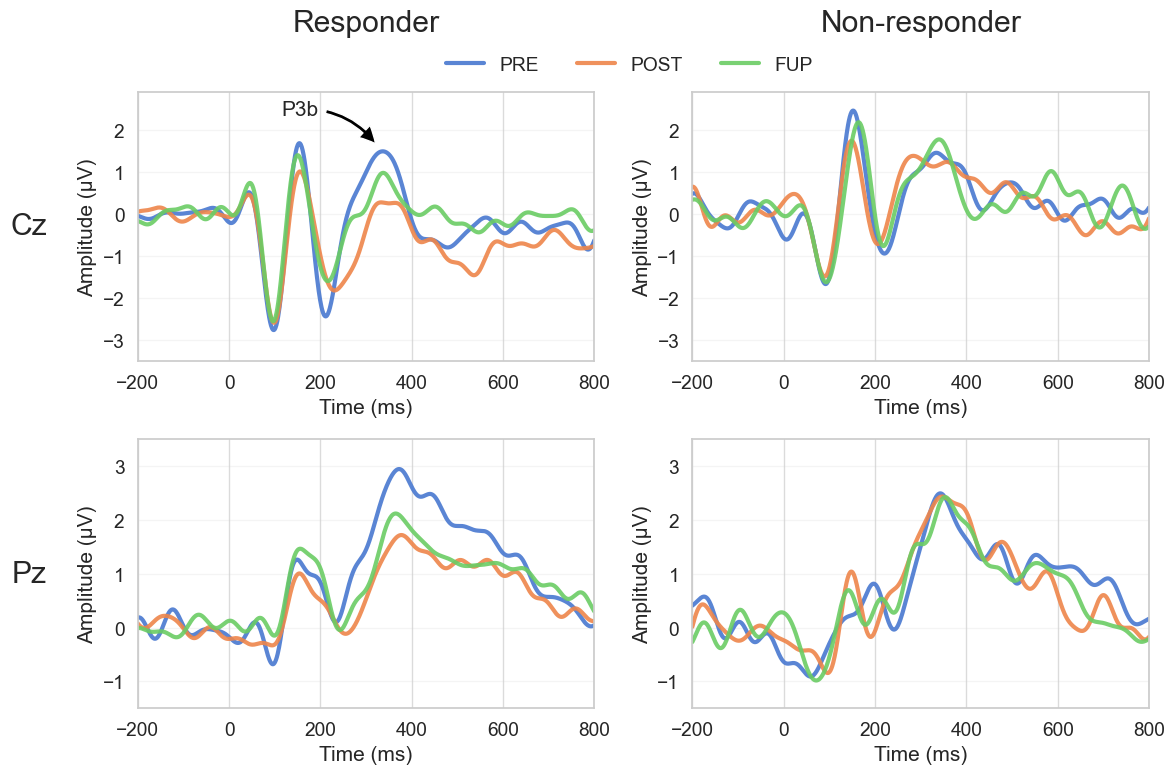

In [8]:
sns.set_theme(context='notebook', font_scale=1.25,
              style='whitegrid', palette='muted',
              font='sans-serif')

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='tight', dpi=100)
for c, ch in enumerate(channels):
    for r in [0, 1]:
        # Exclude the non-responders (0) or responders (1)
        respondance = list(df[df['Responder']==r]['Subject'].unique())
        exclude_subjects = bad_subjects + respondance

        # Loop through each experiment folder
        master_grand_evoked_data = [None]*len(timepoint_folders)
        master_grand_evoked_times = [None]*len(timepoint_folders)
        for tp, timepoint_folder in enumerate(timepoint_folders):
            # Get directories of clean EEG files and exclude the pre-defined subjects
            dir_inprogress = os.path.join(clean_folder, exp_folder, timepoint_folder)
            file_dirs, subject_names = arrange.read_files(dir_inprogress, "_clean-epo.fif",
                                                        exclude_subjects=exclude_subjects,
                                                        verbose=False)

            # Loop through all the subjects' directories (EEG files directories)
            evoked_signal = [None]*len(file_dirs)
            for i in range(len(file_dirs)):
                # Read the clean data from the disk
                epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress,
                                                                            subject_names[i]),
                                                                            verbose=False)
                
                # Create an averaged evoked object from epochs
                evoked_signal[i] = epochs[event_list].average(picks=ch)

            # Average all the averaged evoked objects, thereby creating a grand average signals
            master_grand_evoked_data[tp] = mne.grand_average(evoked_signal).data[0]*1e6
            master_grand_evoked_times[tp] = mne.grand_average(evoked_signal).times*1e3

        # Plot all experiments' grand average signals on a single plot
        for ix in range(len(master_grand_evoked_times)):
            axs[c][r].plot(master_grand_evoked_times[ix], master_grand_evoked_data[ix],
                           linewidth=3, alpha=0.9)

        # Set plot settings
        axs[c][r].set_xlim([-200, 800])
        axs[c][r].set_xlabel('Time (ms)')
        axs[c][r].set_ylabel('Amplitude (µV)')
        axs[c][r].grid(which='major', axis='y', alpha=0.2)
        axs[c][r].grid(which='major', axis='x', alpha=0.7)

        # Set the voltage axis limits same across same channels
        if c==0:
            axs[c][r].set_ylim([-3.5, 2.9])
        if c==1:
            axs[c][r].set_ylim([-1.5, 3.5])

# Annotate the columns and rows headers
for ax, col in zip(axs[0], ['Responder', 'Non-responder']):
    ax.annotate(col, xy=(0.5, 1.2), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline')
for ax, row in zip(axs[:,0], ['Cz', 'Pz']):
    ax.annotate(row, xy=(-1, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center')

fig.legend(list(dict_timepoint.values()), loc='upper center',
           bbox_to_anchor=(0.035,-0.065,1,1), ncols=3, frameon=False)

# Draw the arrow
axs[0][0].annotate('', xy=(325, 1.6), xytext=(205, 2.45),
                   arrowprops=dict(facecolor='black', shrink=0.05,
                                   connectionstyle="arc3,rad=-0.2",
                                   width=3))

# Add the text separately with adjusted position
axs[0][0].text(115, 2.35, 'P3b')

# # Draw the arrow
# axs[1][0].annotate('P3b', xy=(350, 3.2), xytext=(150, 2.9),
#                    arrowprops=dict(facecolor='black', shrink=0.05,
#                                    connectionstyle="arc3,rad=-0.2",
#                                    width=3))
if savefig == True:
    plt.savefig(fname='{}/{}/GRAND_erpfig.png'.format(results_folder, exp_folder), dpi=300)
plt.show()

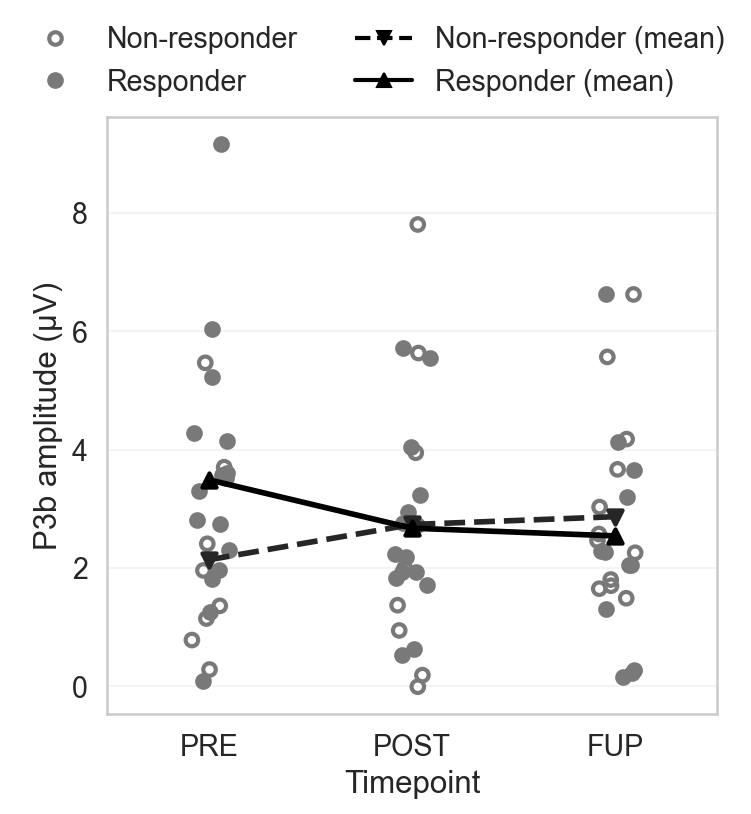

In [29]:
erp_var = 'P3_amplitude'
erp_name = 'P3b amplitude (µV)'

sns.set_theme(context='notebook', font_scale=1.25,
              style='whitegrid', palette='muted',
              font='sans-serif')
muted_colors = sns.color_palette('muted')

strp_args = dict(x='Timepoint', y=erp_var, jitter=True, size=6,
                 edgecolor=muted_colors[7], linewidth=2, zorder=1)

fig, axs = plt.subplots(figsize=(5, 5), layout='tight', dpi=150)

# Stripplot for Non-responders with only outline (use facecolor='none')
strp_nonresp = sns.stripplot(ax=axs, data=df_ch_cat[df_ch_cat['Responder']==0],
                             **strp_args)
for path_collection in strp_nonresp.collections:
    path_collection.set_facecolor('none')

# Stripplot for Responders with outline and fill
strp_resp = sns.stripplot(ax=axs, data=df_ch_cat[df_ch_cat['Responder']==1],
                          facecolor=muted_colors[7], **strp_args)

# Pointplot for both groups
pnt_plt = sns.pointplot(ax=axs, data=df_ch_cat,
                        x='Timepoint', y=erp_var, hue='Responder',
                        errorbar=None, dodge=False, color='black', 
                        markers=['v', '^'], linestyles=['--', '-'])

# Plot settings
axs.set_ylabel(erp_name)
axs.grid(which='major', axis='y', alpha=0.2)

# Create a legend
axs.get_legend().remove()
legend_elements = [plt.Line2D([0], [0], linestyle='', marker='o', color='none',
                              markerfacecolor='none', markeredgecolor=muted_colors[7],
                              markeredgewidth=2, label='Non-responder'),
                   plt.Line2D([0], [0], linestyle='', marker='o', color='none',
                              markerfacecolor=muted_colors[7], markeredgecolor=muted_colors[7],
                              markeredgewidth=2, label='Responder'),
                   plt.Line2D([0], [0], linestyle='--', marker='v', color='black',
                              label='Non-responder (mean)', linewidth=2, markersize=7),
                   plt.Line2D([0], [0], linestyle='-', marker='^', color='black',
                              label='Responder (mean)', linewidth=2, markersize=7)]

legend = fig.legend(handles=legend_elements, loc='upper right',
                    bbox_to_anchor=(0, 0.11, 1, 1), frameon=False, ncol=2)
if savefig == True:
    plt.savefig(fname='{}/{}/{}_plot.png'.format(results_folder, exp_folder, erp_var),
                bbox_extra_artists=[legend,], bbox_inches='tight', dpi=300)
plt.show()
